In [2]:
%matplotlib inline
import numpy as np
from numpy import *
from math import atan2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches

se $z(t)$ è una curva nel piano complesso che in un punto $z_0$ identifica un angolo $\theta$ con l'asse orizzontale, allora la sua immagine tramite inversione circolare identifica un angolo $\pi + 2\alpha-\theta$ dove $\alpha$ è l'argomento del punto (ovvero $z_0 = \lvert z_0 \rvert e^{i\alpha}$).

L'inversione circolare trasforma il cerchio $\lvert z-z_0\rvert = r$ 
nel cerchio $\lvert \zeta-\zeta_0\rvert=\rho$ con
\begin{equation}
\zeta_0 = \frac{z_0}{\lvert z_0\rvert^2 - r^2},
\qquad
\rho = \frac{r}{\lvert z_0\rvert^2 - r^2}
\end{equation}

Se $r_1$, $r_2$ sono i raggi esterni di una doppia bolla e $r$ è il raggio dell'interfaccia tra le due, allora si ha
\begin{equation}
\frac 1 r = 2 \sin \theta,
\qquad 
\frac 1 {r_1} = 2 \sin (\pi/3+\theta),
\qquad
\frac 1 {r_2} = 2 \sin(\pi/3 - \theta)
\end{equation}
dove $\theta$ è l'angolo 

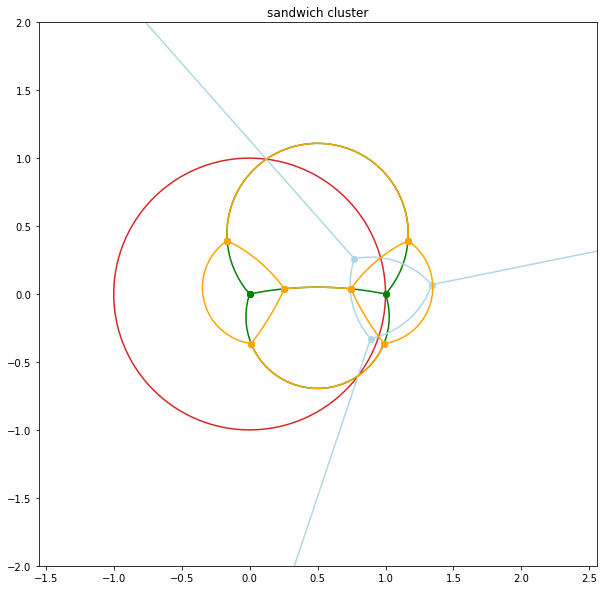

In [94]:
def my_arc(center, radius, start=0.0, end=2*pi):
    t = linspace(start, end, int(1+20*abs(radius*(end-start))))
    x, y = center
    return (x + radius*cos(t), y + radius*sin(t))

def turn_left(v):
    x, y = v
    return array([-y, x])

def sqr(v):
    return (v**2).sum()

def arg(z):
    x, y = z
    return atan2(y, x)

def degrees(angle):
    return angle/pi*180

def my_curve(start, end, angle):
    v = 0.5 * (end-start)
    center = 0.5*(start+end) + turn_left(v) / tan(angle)
    absv = sqrt(sqr(v))
    radius = absv / sin(angle)
    alpha = arg(v) - pi/2 - angle
    while angle > pi:
        angle -= pi
    while angle < - pi:
        angle += pi
    return my_arc(center, radius, alpha, alpha+2*angle)

class Edge(object):
    def __init__(self, start, end, direction):
        self.start = start
        self.end = end
        self.direction = direction # direzione arco uscente da start
        v = 0.5 * (end-start) # semi segmento
        angle = arg(v) - direction
        while angle > pi:
            angle -= 2*pi
        while angle <= -pi:
            angle += 2*pi
        self.angle = angle # angolo tra arco e corda
        self.center = 0.5*(start+end) + turn_left(v) / tan(angle)
        absv = sqrt(sqr(v))
        self.l = 2 * absv # lunghezza corda
        if angle >= 0:
            self.radius = absv / sin(angle)  # raggio 
            self.alpha = arg(v) - pi/2 - angle    # angolo start
            self.beta = self.alpha + 2*angle           # angolo end
        else:
            self.radius = -absv / sin(angle)
            self.alpha = arg(v) + pi/2 - angle
            self.beta = self.alpha + 2*angle
        self.end_direction = direction + 2*angle
        
    def draw(self, plt, *args, **kwargs):
        plt.plot(*my_arc(self.center, self.radius, self.alpha, self.beta), *args, **kwargs)
        
class Cluster(object):
    def __init__(self, color="black"):
        self.vertices = []
        self.edges = []
        self.color = color
        
    def add_vertex(self, v):
        self.vertices.append(v)
        
    def add_vertices(self, vertex_list):
        for v in vertex_list:
            self.add_vertex(v)
    
    def add_edge(self, start, end, direction):
        self.edges.append(Edge(self.vertices[start], self.vertices[end], direction))

    def add_edges(self, edge_list):
        for e in edge_list:
            self.add_edge(*e)
        
    def draw(self, plt):
        for edge in self.edges:
            edge.draw(plt, self.color)
        for vertex in self.vertices:
            plt.plot(*my_points(*self.vertices), color=self.color, linestyle="None", marker="o")
            
def my_line(start, end):
    return zip(start, end)

def my_points(*points):
    return [[p[0] for p in points], [p[1] for p in points]]

def invert(xs, ys):
    """
    circular inversion
    """
    ms = xs**2 + ys**2
    return (xs/ms, ys/ms)

def invert_other(xs, ys):
    """
    circular inversion and symmetry
    """
    ms = xs**2 + ys**2
    return (1-xs/ms, ys/ms)

def inverse_angle(z, angle):
    """
    direction of inverted curve
    """
    return pi + 2*arg(z) - angle


O = array((0.0, 0.0))
P = array((1.0, 0))


class DoubleBubble(Cluster):
    def __init__(self, theta=0.2, color="green"):
        super().__init__(color=color)

        self.add_vertices([O, P])
        self.add_edges([
            (0, 1, theta),
            (0, 1, theta + 2*pi/3),
            (0, 1, theta - 2*pi/3), ])
        

class Sandwich(Cluster):
    def __init__(self, theta=0.2, rho=0.6, color="orange"):
        super().__init__(color=color)
        
        self.theta = theta
        self.rho = rho

        # vertici della configurazione equilatera
        zangles = [theta + 2*k*pi/3 for k in range(3)]  # angoli delle curve uscenti dal triangolo
        zs = [P + rho / sqrt(3) * array((cos(angle), sin(angle))) for angle in zangles]
        self.zs = zs
        
        # vertici del cluster
        ws = [array(invert(*z)) for z in zs] + [array(invert_other(*z)) for z in zs]
        wangles = [inverse_angle(z, angle) for (z, angle) in zip(zs, zangles)]

        # raggio interfaccia interna del cluster
        r = 1/(2*sin(theta))

        self.add_vertices(ws)
        self.add_edges([
            (0, 3, wangles[0]),
            (1, 4, wangles[1]),
            (2, 5, wangles[2]),
            (0, 1, wangles[0]-2*pi/3),
            (0, 2, wangles[0]+2*pi/3),
            (3, 4, 5*pi/3 - wangles[0]),
            (3, 5, pi/3 - wangles[0]), ])

        self.add_edges([
            (1, 2, sandwich.edges[3].end_direction - pi/3),
            (4, 5, sandwich.edges[5].end_direction + pi/3), ])

    def draw_inverted(self, plt, color=None):
        if color is None:
            color = self.color
        M = 10
        for z in self.zs:
            plt.plot(*my_line(z, P+M*(z-P)), color=color)
        plt.plot(*my_points(*self.zs), color=color, marker="o", linestyle="None")
        for i, z in enumerate(self.zs):
            arc = my_arc(z, self.rho, self.theta+(4*i+5)*pi/6, self.theta+(4*i+7)*pi/6)
            plt.plot(*arc, color=color)

        
double_bubble = DoubleBubble()
sandwich = Sandwich()

plt.figure(figsize=(10, 10))

if True: # disegna cerchio di inversione
    plt.plot(*my_arc(O, 1), "C3")
    plt.plot(*my_points(O), "C3o")

double_bubble.draw(plt)
        
sandwich.draw_inverted(plt, "lightblue")

sandwich.draw(plt)

plt.axis('equal')
L = 2
plt.axis([-L+0.5,L+0.5, -L,L])
plt.title('sandwich cluster')
plt.show()